$$ ITI \space AI-Pro: \space Intake \space 44 $$
$$ Machine \space Learning \space 1 $$
$$ Lab \space no. \space 2 $$

# `01` Import Necessary Libraries

## `i` Default Libraries

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

## `ii` Additional Libraries
Add imports for additional libraries you used throughout the notebook

In [133]:
import numpy as np 
import matplotlib as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from zlib import crc32
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model


----------------------------

# `02` Load Data

In [78]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## `#` Create Test Set

Before exploring the data, let's split the data into training and test sets. You shouldn't touch the test set from this point furthur except for final model evaluation.

Use:
- `random_state` $= 1234$
- `test_size` $= 0.2$

Hint: You can use `sklearn.model_selection.train_test_split` function

In [79]:
train_set ,test_set=train_test_split(housing ,random_state=1234,test_size=.2)

In [80]:
print(len(train_set))
print(len(test_set))

16512
4128


#### A function that do the same thing as train_test_split

In [81]:
def id_in_test_set(identifier , test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32 #this function makes sure that the data do not change using crc32
def train_test_split(data,test_ratio ,id_column):
    ids=data[id_column]
    in_test_set = ids.apply(lambda id_:id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [82]:
housing_id=housing.reset_index() #adding the indecis as a column in the data frame

In [83]:
train, test = train_test_split(housing_id, 0.2, "index")

In [84]:
print(len(train))
print(len(test))

16512
4128


----------------

# `03` Exploratory Data Analysis (EDA)

## `i` Simple Analysis

Preview data, perform statistical data analysis and explore as much as needed to better understand the data set we're dealing with.

`Note:` Feel free to look up EDA approaches online for inspiration (however you **must understand** everything and not copy paste).

In [85]:
housing=train_set.copy()

In [86]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17595,-120.07,36.98,12.0,1790.0,379.0,1399.0,397.0,2.5388,59600.0,INLAND
6073,-118.22,33.86,16.0,8732.0,1489.0,3944.0,1493.0,5.1948,203500.0,<1H OCEAN
6251,-120.94,39.32,14.0,3120.0,595.0,1569.0,556.0,3.5385,157400.0,INLAND
3161,-122.11,37.68,37.0,1976.0,481.0,1197.0,465.0,2.5772,170200.0,NEAR BAY
1887,-121.34,38.67,35.0,643.0,117.0,331.0,134.0,3.0417,120700.0,INLAND


In [87]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 17595 to 1318
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


#### => all columns are float except for ocean_proximity that we can encode => there are 207 missing values in total_bedrooms

In [88]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.576297,35.640944,28.629300,2634.395652,537.400086,1422.226562,499.014595,3.869583,207185.675327
std,2.008301,2.141025,12.622547,2195.367194,422.272540,1119.964665,383.148507,1.896395,115624.027082
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.802500,33.930000,18.000000,1452.750000,296.000000,786.000000,280.000000,2.562500,119800.000000
50%,-118.500000,34.260000,29.000000,2128.000000,435.000000,1166.000000,410.000000,3.539400,180400.000000
75%,-118.010000,37.720000,37.000000,3138.250000,646.000000,1720.000000,603.000000,4.748350,265600.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


## `ii` Visual Analysis

Plot graphs and relations in order to gain more insights about the data set, identify patterns, and make assumptions.

`Note:` Feel free to look up visual EDA approaches online for inspiration (however you **must understand** everything and not copy paste).

<Axes: xlabel='longitude', ylabel='latitude'>

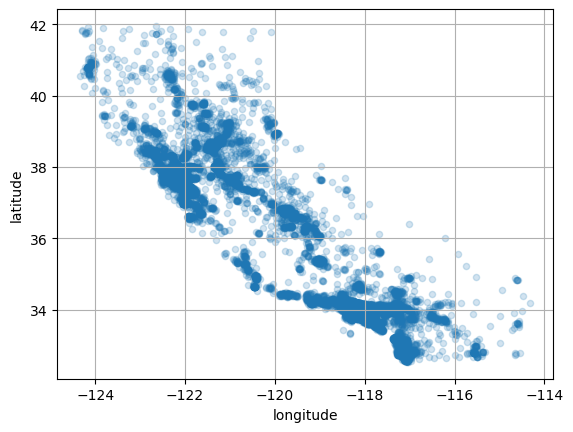

In [89]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)


#### this plot shows the high-density areas colored in dark blue

<Axes: xlabel='longitude', ylabel='latitude'>

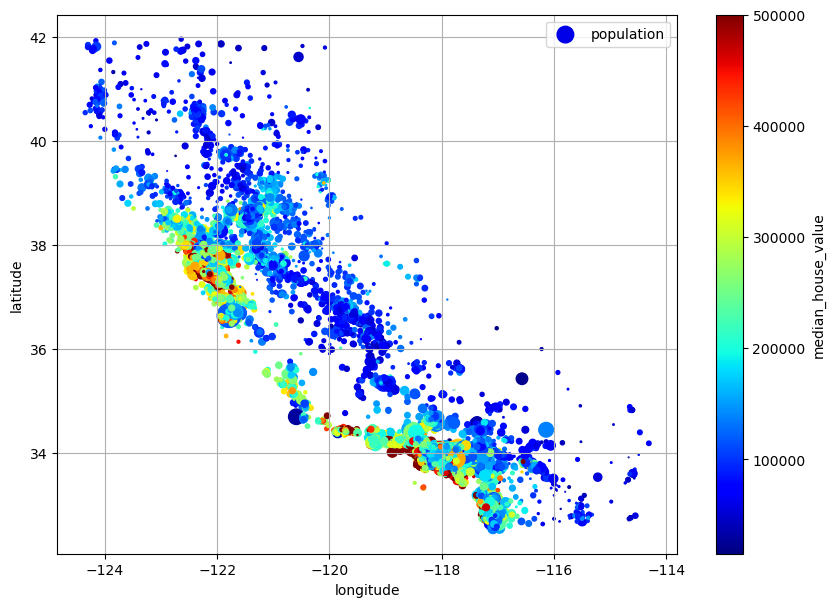

In [90]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

#### this figure tells us that the house value is related to the location and the population density as well

## looking for correlations

In [91]:
corr_matrix = housing.corr(numeric_only=True)

In [92]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689988
total_rooms           0.131754
housing_median_age    0.108490
households            0.062802
total_bedrooms        0.045670
population           -0.025377
longitude            -0.041624
latitude             -0.149469
Name: median_house_value, dtype: float64

#### It appears that there is a strong correlation between median income and house value so i will plot these 2 together

<Axes: xlabel='median_income', ylabel='median_house_value'>

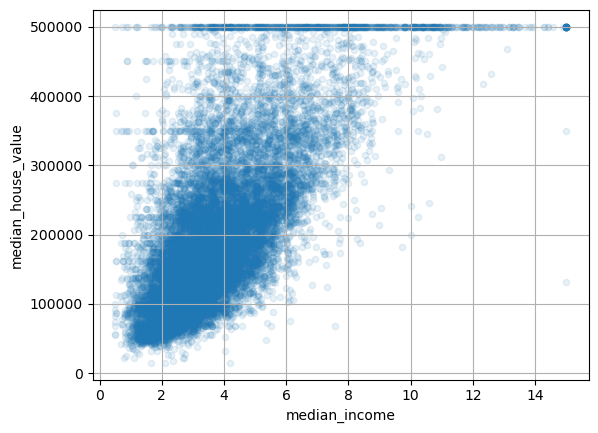

In [93]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)

#### This figure shows that : * strong correlation (upward trend) *there is a price cap at 500000 , 250000 and 450000

----------------

# `04` Data Preparation

Perform data cleaning, feature engineering, scaling, etc. as needed to make sure it's ready for the model.

Hint: It could be helpful to check `sklearn.preprocessing` module.

In [94]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

In [95]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17595,-120.07,36.98,12.0,1790.0,379.0,1399.0,397.0,2.5388,INLAND
6073,-118.22,33.86,16.0,8732.0,1489.0,3944.0,1493.0,5.1948,<1H OCEAN
6251,-120.94,39.32,14.0,3120.0,595.0,1569.0,556.0,3.5385,INLAND
3161,-122.11,37.68,37.0,1976.0,481.0,1197.0,465.0,2.5772,NEAR BAY
1887,-121.34,38.67,35.0,643.0,117.0,331.0,134.0,3.0417,INLAND
...,...,...,...,...,...,...,...,...,...
8222,-120.04,36.79,48.0,1341.0,239.0,671.0,208.0,2.7917,INLAND
9449,-118.18,36.63,23.0,2311.0,487.0,1019.0,384.0,2.2574,INLAND
8471,-119.71,34.43,47.0,1572.0,417.0,790.0,384.0,2.6429,<1H OCEAN
17048,-117.92,33.62,35.0,1821.0,335.0,727.0,316.0,6.5842,<1H OCEAN


#### NaN values

In [96]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
495,-114.59,34.83,41.0,812.0,NaN,375.0,158.0,1.7083,INLAND
9947,-117.98,33.68,24.0,4177.0,NaN,1704.0,606.0,6.2473,<1H OCEAN
4919,-121.13,38.87,48.0,1127.0,NaN,530.0,186.0,3.0917,INLAND
5971,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
19614,-118.20,33.92,45.0,1283.0,NaN,1025.0,248.0,3.2798,<1H OCEAN


In [97]:
imputer = SimpleImputer(strategy="median")

In [98]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [99]:
X = imputer.transform(housing_num)

In [100]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [101]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17595,-120.07,36.98,12.0,1790.0,379.0,1399.0,397.0,2.5388
6073,-118.22,33.86,16.0,8732.0,1489.0,3944.0,1493.0,5.1948
6251,-120.94,39.32,14.0,3120.0,595.0,1569.0,556.0,3.5385
3161,-122.11,37.68,37.0,1976.0,481.0,1197.0,465.0,2.5772
1887,-121.34,38.67,35.0,643.0,117.0,331.0,134.0,3.0417


#### Handling Text and Categorical Attributes"ocean proximity"

In [102]:
housing["ocean_proximity"].value_counts() 

ocean_proximity
<1H OCEAN     7256
INLAND        5267
NEAR OCEAN    2139
NEAR BAY      1846
ISLAND           4
Name: count, dtype: int64

In [103]:
le = LabelEncoder()
housing['ocean_proximity']=le.fit_transform(housing['ocean_proximity'])
housing['ocean_proximity'].value_counts()

ocean_proximity
0    7256
1    5267
4    2139
3    1846
2       4
Name: count, dtype: int64

In [104]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 17595 to 1318
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  int32  
dtypes: float64(8), int32(1)
memory usage: 1.2 MB


#### piplines

In [107]:

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [111]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
#         ("cat", LabelEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

## `#` Prepare Test Set

Apply the data transformations you used on the training set to the test set.

**Important Note:** DO NOT use `fit` on the test set.

In [112]:
test = test_set.drop("median_house_value", axis=1)
test_labels = test_set["median_house_value"].copy()

In [113]:
test_num = test.select_dtypes(include=[np.number])
test_imputed = imputer.transform(test_num)

In [114]:
test['ocean_proximity']=le.transform(test['ocean_proximity'])
test['ocean_proximity'].value_counts()

ocean_proximity
0    1880
1    1284
4     519
3     444
2       1
Name: count, dtype: int64

In [115]:
test_scaled = ro_scaler.transform(test)

----------------------------

# `05` Normal Equation

Using `sklearn` implementation of the linear regression closed-form solution, i.e. normal equation, to model the data.

Hint: Look for `sklearn.linear_model.LinearRegression` class.

## `i` Model Training

Initializing the model, fitting it to the training data, and get a fitted model.

In [39]:
reg = LinearRegression()

In [116]:
reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [118]:
housing_predictions = reg.predict(housing_prepared)
housing_predictions[:5].round(-2) 


array([ 83700., 278500.,  78900., 192500., 122600.])

In [119]:
housing_labels.iloc[:5].values

array([ 59600., 203500., 157400., 170200., 120700.])

## `ii` Model Evaluation

Evaluate model performance using several metrics, e.g. **RMSE**, **MAE**, $R^2$. etc.

In [120]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse



69407.04618521429

In [121]:
r2=r2_score(housing_labels, housing_predictions)
r2

0.6396394475262139

In [122]:
mae=mean_absolute_error(housing_labels, housing_predictions)
mae

50925.16364568662

----------------------

# `06` Linear Regression with Gradient Descent

Using `sklearn` implementation of linear regression to model the data.

Hint: Look for `sklearn.linear_model.SGDRegressor` class.

## `i` Baseline Model Training

Initializing the model with initial parameters, fitting it to the training data, and get a baseline model.

Use:
- Non-regularized model.
- Constant `learning_rate`

In [123]:
reg=SGDRegressor(max_iter=1000, tol=1e-3, random_state=1234)

In [124]:
reg.fit(housing_prepared,housing_labels)

SGDRegressor(random_state=1234)

In [127]:
housing_predictions = reg.predict(housing_prepared)
housing_predictions[:5].round(-2) 

array([ 87500., 272100.,  83700., 195000., 127100.])

In [128]:
housing_labels.iloc[:5].values

array([ 59600., 203500., 157400., 170200., 120700.])

## `ii` Model Evaluation

Evaluate the baseline model performance using several metrics, e.g. **RMSE**, **MAE**, $R^2$. etc.

In [129]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse


69508.31912755915

In [130]:
r2=r2_score(housing_labels, housing_predictions)
r2


0.6385870645040828

In [131]:
mae=mean_absolute_error(housing_labels, housing_predictions)
mae

50864.658994496654

## `iii` Tune `learning_rate`

Try different `learning_rate` values and evaluate. What is the optimal learning rate?

Hint: You might want to use `sklearn.model_selection.RandomizedSearchCV` or `sklearn.model_selection.GridSearchCV` classes.

In [135]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    
  ]

forest_reg = RandomForestRegressor(random_state=1234)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [136]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [137]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=1234)

## `iv` Regularization Mode: On

Let's try $l_1$ and $l_2$ regularization. Use default parameters for simplicity. Does regularization made the model generalize better?

Which of the two regularizations performs better?

#### l1


In [138]:
clf = Ridge(alpha=1.0)
clf.fit(housing_prepared, housing_labels)


Ridge()

In [139]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse


69508.31912755915

#### l2

In [141]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(housing_prepared, housing_labels)


Lasso(alpha=0.1)

In [142]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

69508.31912755915

------------------

# `07` Generalization Error

Now that we have tuned our solution, to an *extent*, we need to test for a final time on the held out test set.

In [143]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [144]:
final_rmse

49077.08824540951

-----------------------------

# `Bonus` Better Flow

For the model to be production-ready, we need to integrate it into a pipeline along with the data preparation flow.

Hint: Look up `sklearn.pipeline.Pipeline` class.

In [153]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", grid_search.best_estimator_)
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
pipline_prdictions=full_pipeline_with_predictor.predict(test_set)

In [154]:
mse = mean_squared_error(y_test, pipline_prdictions)
rmse = np.sqrt(mse)

In [155]:
rmse

49077.08824540951

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$